In [ ]:
import kagglehub

# Download the dataset
try:
    base_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", base_path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

In [ ]:
import os
import shutil

# Define paths
source_base_path = os.path.join(base_path, "YOLO_format")  # Add YOLO_format to the downloaded path
destination_base_path = os.path.join(os.getcwd(), "AffectNET_Unorganised")  # Place organised data in 'AffectNET' folder

# Define emotions
emotions = [
    "Anger",
    "Contempt",
    "Disgust",
    "Fear",
    "Happy",
    "Neutral",
    "Sad",
    "Surprise",
]

# Define function to organize files
def organize_affectnet(source_base_path, destination_base_path, split):
    source_images_path = os.path.join(source_base_path, split, "images")
    source_labels_path = os.path.join(source_base_path, split, "labels")

    if not os.path.exists(source_images_path) or not os.path.exists(source_labels_path):
        print(f"Warning: {split} images or labels path does not exist. Skipping.")
        return

    destination_split_path = os.path.join(destination_base_path, f"{split}_organised")

    # Create destination directories for emotions
    for emotion in emotions:
        emotion_folder = os.path.join(destination_split_path, emotion)
        os.makedirs(emotion_folder, exist_ok=True)

    # Move and organize files
    for label_file in os.listdir(source_labels_path):
        if label_file.endswith(".txt"):
            label_path = os.path.join(source_labels_path, label_file)

            # Handle both .jpg and .png image extensions
            image_file_jpg = label_file.replace(".txt", ".jpg")
            image_file_png = label_file.replace(".txt", ".png")

            source_image_path_jpg = os.path.join(source_images_path, image_file_jpg)
            source_image_path_png = os.path.join(source_images_path, image_file_png)

            if os.path.exists(source_image_path_jpg) or os.path.exists(source_image_path_png):
                source_image_path = source_image_path_jpg if os.path.exists(source_image_path_jpg) else source_image_path_png

                with open(label_path, "r") as f:
                    labels = f.readlines()

                for label in labels:
                    label_data = label.strip().split()
                    emotion_index = int(label_data[0])  # Emotion class index
                    if emotion_index < len(emotions):
                        emotion = emotions[emotion_index]
                        destination_image_path = os.path.join(destination_split_path, emotion, os.path.basename(source_image_path))
                        shutil.copy(source_image_path, destination_image_path)
                        break  # Move the image based on the first valid label
            else:
                print(f"Image {image_file_jpg} or {image_file_png} not found for label {label_file}")

# Function to copy everything from source_base_path to destination_base_path without organising, in the source folder the structure is train/valid/test
def copy_all(source_base_path, destination_base_path):
    for split in ["train", "valid", "test"]:
        source_split_path = os.path.join(source_base_path, split)
        destination_split_path = os.path.join(destination_base_path, split)

        if not os.path.exists(source_split_path):
            print(f"Warning: {split} path does not exist. Skipping.")
            continue

        os.makedirs(destination_split_path, exist_ok=True)

        # copy the images from test/train/valid to the destination folder without organizing them (to destination_base_path/train, destination_base_path/valid, destination_base_path/test)
        for folder in os.listdir(source_split_path):
            source_folder_path = os.path.join(source_split_path, folder)
            destination_folder_path = os.path.join(destination_split_path, folder)

            if not os.path.exists(source_folder_path):
                print(f"Warning: {folder} path does not exist. Skipping.")
                continue

            os.makedirs(destination_folder_path, exist_ok=True)

            for file in os.listdir(source_folder_path):
                source_file_path = os.path.join(source_folder_path, file)
                destination_file_path = os.path.join(destination_folder_path, file)

                if os.path.isfile(source_file_path):
                    shutil.copy(source_file_path, destination_file_path)


# Create the main AffectNET directory
os.makedirs(destination_base_path, exist_ok=True)

# Organize train, valid, and test datasets
# for split in ["train", "valid", "test"]:
#     organize_affectnet(source_base_path, destination_base_path, split)

# Copy everything from source_base_path to destination_base_path without organising
copy_all(source_base_path, destination_base_path)

print("Dataset organization complete.")



In [17]:
import os

# ✅ Move these settings before importing TensorFlow
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "4"  # Set inter-op parallelism
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "4"  # Set intra-op parallelism

import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
import random
import logging
from PyQt6.QtWidgets import QApplication, QLabel, QHBoxLayout, QVBoxLayout, QPushButton, QWidget
from PyQt6.QtGui import QPixmap
from PyQt6.QtCore import Qt
from PIL import Image, ImageQt

In [18]:
# Suppress TensorFlow progress bar
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [19]:
class DataProcessor:
    def __init__(self, dataset_path, emotions, ORGANISED):
        self.dataset_path = dataset_path
        self.emotions = emotions
        self.organised = ORGANISED

        # Automatically set paths for train, valid, and test
        if ORGANISED:
            self.train_path = os.path.join(dataset_path, "train_organised")
            self.valid_path = os.path.join(dataset_path, "valid_organised")
            self.test_path = os.path.join(dataset_path, "test_organised")
        else:
            self.train_path = os.path.join(dataset_path, "train")
            self.valid_path = os.path.join(dataset_path, "valid")
            self.test_path = os.path.join(dataset_path, "test")

    def load_affectnet_organised_dataset(self, dataset_path, image_size=(128, 128)):
        images = []
        labels = []

        print(f"Loading images from: {dataset_path}")

        total_images = 0  # Keep track of total images

        for label, emotion in enumerate(self.emotions):
            folder_path = os.path.join(dataset_path, emotion)
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} does not exist. Skipping.")
                continue

            emotion_images = 0
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jpg") or file_name.endswith(".png"):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        image = cv2.imread(file_path)
                        if image is None:
                            continue
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, image_size)
                        images.append(image)
                        labels.append(label)
                        emotion_images += 1
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")
            
            total_images += emotion_images

        images = np.array(images, dtype="float32") / 255.0
        labels = np.array(labels)

        print(f"Loaded {total_images} images from {dataset_path}.")
        return images, labels

    def load_affectnet_unorganised_dataset(self, dataset_path, image_size=(128, 128)):
        images = []
        labels = []

        print(f"Loading images from: {dataset_path}")

        images_path = os.path.join(dataset_path, "images")
        labels_path = os.path.join(dataset_path, "labels")

        if not os.path.exists(images_path) or not os.path.exists(labels_path):
            print(f"Warning: Image or label path does not exist in {dataset_path}. Skipping.")
            return np.array([]), np.array([])

        for file_name in os.listdir(images_path):
            if file_name.endswith(".jpg") or file_name.endswith(".png"):
                file_path = os.path.join(images_path, file_name)
                try:
                    image = cv2.imread(file_path)
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, image_size)
                    images.append(image)

                    # Load the corresponding label
                    label_file = file_name.replace(".jpg", ".txt").replace(".png", ".txt")
                    label_path = os.path.join(labels_path, label_file)
                    with open(label_path, "r") as f:
                        label_line = f.readline().strip().split()
                        label = int(label_line[0])  # Take only the first number (emotion class)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")

        images = np.array(images, dtype="float32") / 255.0
        labels = np.array(labels)

        print(f"Loaded {len(images)} images from {dataset_path}.")
        return images, labels

    def prepare_datasets(self):
        if self.organised:
            X_train, y_train = self.load_affectnet_organised_dataset(self.train_path)
            X_val, y_val = self.load_affectnet_organised_dataset(self.valid_path)
            X_test, y_test = self.load_affectnet_organised_dataset(self.test_path)
        else:
            X_train, y_train = self.load_affectnet_unorganised_dataset(self.train_path)
            X_val, y_val = self.load_affectnet_unorganised_dataset(self.valid_path)
            X_test, y_test = self.load_affectnet_unorganised_dataset(self.test_path)

        y_train = to_categorical(y_train, num_classes=len(self.emotions))
        y_val = to_categorical(y_val, num_classes=len(self.emotions))
        y_test = to_categorical(y_test, num_classes=len(self.emotions))

        return X_train, y_train, X_val, y_val, X_test, y_test

    def show_example(self, dataset="train", image_size=(128, 128)):
        """
        Shows an example image from the specified dataset (train, valid, or test).
        """
        dataset_path = (
            self.train_path if dataset == "train" else
            self.valid_path if dataset == "valid" else
            self.test_path
        )

        if self.organised:
            images, labels = self.load_affectnet_organised_dataset(dataset_path, image_size=image_size)
        else:
            images, labels = self.load_affectnet_unorganised_dataset(dataset_path, image_size=image_size)

        if len(images) == 0:
            print("No images found in the dataset.")
            return

        idx = random.randint(0, len(images) - 1)
        image = (images[idx] * 255).astype(np.uint8)
        label = self.emotions[labels[idx]]

        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()


Testing Organised Dataset:
Loading images from: ./AffectNET_Organised/train_organised
Loaded 17101 images from ./AffectNET_Organised/train_organised.


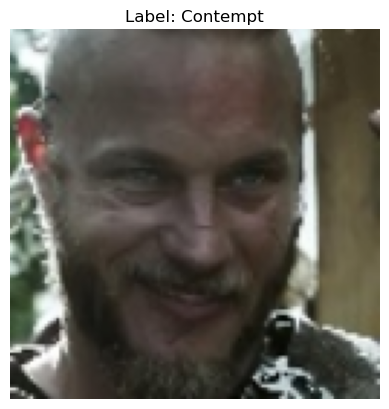


Testing Unorganised Dataset:
Loading images from: ./AffectNET_Unorganised/train
Loaded 17101 images from ./AffectNET_Unorganised/train.


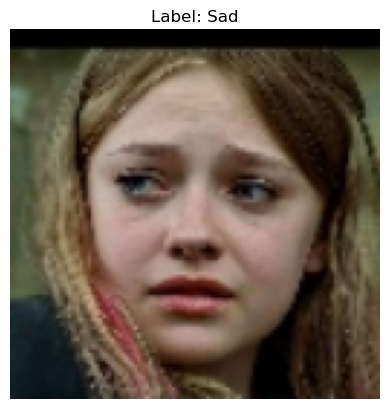

In [20]:
# Test Function for DataProcessor
if __name__ == "__main__":
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

    print("Testing Organised Dataset:")
    organised_path = "./AffectNET_Organised"
    processor = DataProcessor(organised_path, EMOTIONS, ORGANISED=True)
    processor.show_example(dataset="train")

    print("\nTesting Unorganised Dataset:")
    unorganised_path = "./AffectNET_Unorganised"
    processor2 = DataProcessor(unorganised_path, EMOTIONS, ORGANISED=False)
    processor2.show_example(dataset="train")

In [21]:
class FeatureExtraction:
    def __init__(self):
        # Load MobileNetV2 as a feature extractor (without classification head)
        base_model = MobileNet(weights="imagenet", include_top=False, pooling="avg", input_shape=(128, 128, 3))
        base_model.trainable = False  # This ensures only the classifier is trained
        self.feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
        
    def extract_features(self, image):
        """
        Extracts feature vector from an image using MobileNetV2.
        """
        image = cv2.resize(image, (128, 128))  # Resize to MobileNetV2 input size
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        image = image / 255.0  # Normalize
        features = self.feature_extractor.predict(image, verbose=0)
        return features

    @staticmethod
    def visualize_features(image, feature_extractor):
        """
        Visualizes extracted feature maps as a heatmap overlay on the image.
        """
        if feature_extractor is None:
            raise ValueError("Feature extractor is not initialized.")

        # Extract feature maps
        features = feature_extractor.predict(np.expand_dims(image, axis=0), verbose=0)
        feature_map = np.max(features, axis=-1)  # Max pooling to highlight strong activations
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize

        # Resize feature map to match image size
        feature_map = cv2.resize(feature_map, (image.shape[1], image.shape[0]))

        # Convert to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * feature_map), cv2.COLORMAP_JET)

        # Overlay heatmap on the original image
        overlay_image = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

        # Display
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_image)
        plt.title("Feature Map Overlay")
        plt.axis("off")

        plt.show()

In [22]:
class EmotionCNN:
    def __init__(self, emotions):
        self.emotions = emotions
        self.feature_extractor = None  # Will use a pre-trained extractor
        self.emotion_classifier = None
        self.combined_model = None
        self.history = None  # Stores training history

    def build_emotion_classifier(self, input_shape):
        """
        Builds the classifier that takes pre-trained features and predicts emotions.
        """
        inputs = Input(shape=input_shape)
        x = Dense(128, activation="relu")(inputs)
        x = Dropout(0.3)(x)
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.3)(x)
        outputs = Dense(len(self.emotions), activation="softmax")(x)
        self.emotion_classifier = Model(inputs, outputs, name="EmotionClassifier")
        return self.emotion_classifier

    def build_combined_model(self, feature_extractor):
        """
        Combines the pre-trained feature extractor with the classifier.
        """
        self.feature_extractor = feature_extractor  # Use the pre-trained MobileNetV2
        
        inputs = Input(shape=(128, 128, 3))
        features = self.feature_extractor(inputs)
        outputs = self.build_emotion_classifier((features.shape[-1],))(features)
        self.combined_model = Model(inputs, outputs, name="EmotionRecognitionModel")
        return self.combined_model

    def compile_and_train(self, X_train, y_train, X_val, y_val, model_save_path, epochs=10, batch_size=32):
        """
        Compiles and trains the model, storing training history.
        """
        if self.combined_model is None:
            print("No model found. Build and compile the model first.")
            return
        
        self.combined_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        self.history = self.combined_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size
        )
        self.combined_model.save(model_save_path)
        print(f"Model saved at {model_save_path}")

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the model on test data and prints accuracy.
        """
        if self.combined_model is None:
            print("No model found. Train and compile the model first.")
            return

        test_loss, test_accuracy = self.combined_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

    def plot_training_history(self):
        """
        Plots training & validation loss and accuracy curves.
        Helps diagnose overfitting and underfitting.
        """
        if self.history is None:
            print("No training history found. Train the model first.")
            return

        # Extract history data
        history_dict = self.history.history

        # Loss plot
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_dict["loss"], label="Training Loss")
        plt.plot(history_dict["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training & Validation Loss")

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history_dict["accuracy"], label="Training Accuracy")
        plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Training & Validation Accuracy")

        plt.show()

    def evaluate_model_with_confusion_matrix(self, X_test, y_test):
        """
        Evaluates the model and displays a confusion matrix.
        """
        if self.combined_model is None:
            print("No model found. Train and compile the model first.")
            return

        y_pred = self.combined_model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        cm = confusion_matrix(y_true, y_pred_classes)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.emotions, yticklabels=self.emotions)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=self.emotions))


In [23]:
if __name__ == "__main__":
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

    # Load dataset
    processor = DataProcessor("./AffectNET_Unorganised", EMOTIONS, ORGANISED=False)
    X_train, y_train, X_val, y_val, X_test, y_test = processor.prepare_datasets()

    # Initialize pre-trained feature extractor
    feature_extractor = FeatureExtraction().feature_extractor

    # Initialize and train EmotionCNN
    model = EmotionCNN(EMOTIONS)
    model.build_combined_model(feature_extractor)
    model.compile_and_train(X_train, y_train, X_val, y_val, "emotion_model.h5", epochs=20, batch_size=8)

    # Analyze training
    model.plot_training_history()

    # Evaluate on test set
    model.evaluate_model_with_confusion_matrix(X_test, y_test)


Loading images from: ./AffectNET_Unorganised/train
Loaded 17101 images from ./AffectNET_Unorganised/train.
Loading images from: ./AffectNET_Unorganised/valid
Loaded 5406 images from ./AffectNET_Unorganised/valid.
Loading images from: ./AffectNET_Unorganised/test
Loaded 2755 images from ./AffectNET_Unorganised/test.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - accuracy: 0.3176 - loss: 1.8130 - val_accuracy: 0.4256 - val_loss: 1.5291
Epoch 2/20
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.4536 - loss: 1.4681 - val_accuracy: 0.4464 - val_loss: 1.4930
Epoch 3/20
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.4873 - loss: 1.3767 - val_accuracy: 0.4417 - val_loss: 1.4970
Epoch 4/20
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.5245 - loss: 1.2925 - val_accuracy: 0.4589 - val_loss: 1.5024
Epoch 5/20
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.5553 - loss: 1.2147 - val_accuracy

KeyboardInterrupt: 

In [ ]:
class EmotionDetectionSystem:
    def __init__(self, train_path, valid_path, test_path, emotions, model_save_path):
        self.data_processor = DataProcessor(train_path, valid_path, test_path, emotions)
        self.emotion_cnn = EmotionCNN(emotions)
        self.model_save_path = model_save_path
        self.dataset, self.labels = self.data_processor.load_affectnet_unorganised_dataset(train_path)

        # Ensure the feature extractor is built
        if self.emotion_cnn.feature_extractor is None:
            self.emotion_cnn.build_feature_extractor()

    def run(self):
        # Prepare data
        X_train, y_train, X_val, y_val, X_test, y_test = self.data_processor.prepare_datasets()

        # Train or load model
        self.emotion_cnn.compile_and_train(X_train, y_train, X_val, y_val, self.model_save_path)

        # Evaluate model
        test_loss, test_accuracy = self.emotion_cnn.combined_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        # Live feed for emotion detection
        # self.live_camera_feed()

        # Visualize images with GUI
        self.visualize_images_with_gui()

    def live_camera_feed(self):
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error: Camera not found or cannot be opened.")
            return

        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

        cv2.namedWindow("Emotion Recognition", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Emotion Recognition", 1280, 720)

        print("Press 'q' to quit.")
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Unable to read frame from camera.")
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_normalized = frame_rgb / 255.0
            frame_resized = cv2.resize(frame_normalized, (128, 128))

            prediction = self.emotion_cnn.combined_model.predict(np.expand_dims(frame_resized, axis=0), verbose=0)
            predicted_emotion = self.data_processor.emotions[np.argmax(prediction)]

            cv2.putText(
                frame,
                f"Emotion: {predicted_emotion}",
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )

            cv2.imshow("Emotion Recognition", frame)

            if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("Emotion Recognition", cv2.WND_PROP_VISIBLE) < 1:
                break

        cap.release()
        cv2.destroyAllWindows()

    def visualize_images_with_gui(self):
        class EmotionViewer(QWidget):
            def __init__(self, dataset, labels, emotions, feature_extractor, combined_model, parent=None):
                super().__init__(parent)
                self.dataset = dataset
                self.labels = labels
                self.emotions = emotions
                self.feature_extractor = feature_extractor
                self.combined_model = combined_model
                self.init_ui()

            def init_ui(self):
                self.setWindowTitle("Emotion Recognition Viewer")

                # Layout setup
                self.layout = QVBoxLayout()
                self.image_layout = QHBoxLayout()

                self.original_image_label = QLabel()
                self.original_image_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
                self.overlay_image_label = QLabel()
                self.overlay_image_label.setAlignment(Qt.AlignmentFlag.AlignCenter)

                self.image_layout.addWidget(self.original_image_label)
                self.image_layout.addWidget(self.overlay_image_label)

                self.label_layout = QHBoxLayout()
                self.original_label = QLabel("Original Image")
                self.overlay_label = QLabel("Image with Overlay")

                self.label_layout.addWidget(self.original_label)
                self.label_layout.addWidget(self.overlay_label)

                self.next_button = QPushButton("Next Image")
                self.next_button.clicked.connect(self.load_next_image)

                self.layout.addLayout(self.image_layout)
                self.layout.addLayout(self.label_layout)
                self.layout.addWidget(self.next_button)

                self.setLayout(self.layout)
                self.load_next_image()

            def load_next_image(self):
                idx = random.randint(0, len(self.dataset) - 1)
                image = self.dataset[idx]
                label = self.emotions[self.labels[idx]]

                # Get the model's prediction
                prediction = self.combined_model.predict(np.expand_dims(image, axis=0), verbose=0)
                guessed_emotion = self.emotions[np.argmax(prediction)]

                # Convert original image
                original_image = (image * 255).astype(np.uint8)  # Scale to 0-255
                original_image_pil = Image.fromarray(original_image)
                original_qpixmap = QPixmap.fromImage(ImageQt.ImageQt(original_image_pil))
                self.original_image_label.setPixmap(original_qpixmap)

                # Create overlay
                if self.feature_extractor is not None:
                    try:
                        overlay_image, _ = FeatureExtraction.visualize_features(image, self.feature_extractor)
                        overlay_image_pil = Image.fromarray(overlay_image)
                        overlay_qpixmap = QPixmap.fromImage(ImageQt.ImageQt(overlay_image_pil))
                        self.overlay_image_label.setPixmap(overlay_qpixmap)
                    except Exception as e:
                        print(f"Error in generating overlay: {e}")
                        self.overlay_image_label.clear()

                # Update labels
                self.original_label.setText(f"Original Image (Label: {label})")
                self.overlay_label.setText(f"Image with Overlay (Guessed: {guessed_emotion})")

        app = QApplication([])
        viewer = EmotionViewer(self.dataset, self.labels, self.data_processor.emotions, self.emotion_cnn.feature_extractor, self.emotion_cnn.combined_model)
        viewer.show()
        app.exec()


In [ ]:
# Test Function for EmotionDetectionSystem
if __name__ == "__main__":
    TRAIN_PATH = "./AffectNET/train_organised"
    VALID_PATH = "./AffectNET/valid_organised"
    TEST_PATH = "./AffectNET/test_organised"
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    MODEL_SAVE_PATH = "emotion_recognition_model.h5"

    system = EmotionDetectionSystem(TRAIN_PATH, VALID_PATH, TEST_PATH, EMOTIONS, MODEL_SAVE_PATH)

    # Ensure feature extractor and classifier are initialized
    if system.emotion_cnn.combined_model is None:
        system.emotion_cnn.build_combined_model()

    # Show an example image and its overlay with predictions
    random_idx = random.randint(0, len(system.dataset) - 1)
    example_image = system.dataset[random_idx]
    label = system.data_processor.emotions[system.labels[random_idx]]

    # Get prediction and overlay
    prediction = system.emotion_cnn.combined_model.predict(np.expand_dims(example_image, axis=0), verbose=0)
    guessed_emotion = system.data_processor.emotions[np.argmax(prediction)]
    overlay_image, _ = FeatureExtraction.visualize_features(example_image, system.emotion_cnn.feature_extractor)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow((example_image * 255).astype(np.uint8))
    plt.title(f"Original Image (Label: {label})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image)
    plt.title(f"Overlay Image (Guessed: {guessed_emotion})")
    plt.axis("off")

    plt.show()


In [ ]:
if __name__ == "__main__":
    TRAIN_PATH = "./AffectNET/train_organised"
    VALID_PATH = "./AffectNET/valid_organised"
    TEST_PATH = "./AffectNET/test_organised"
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    MODEL_SAVE_PATH = "emotion_recognition_model.h5"

    system = EmotionDetectionSystem(TRAIN_PATH, VALID_PATH, TEST_PATH, EMOTIONS, MODEL_SAVE_PATH)
    system.run()